# Experiments demo for CS159 project

This is a colab demonstration of how our small library can be used to set up encoding datasets using different sets and aggregation functions.

## Colab setup

Installing necessary libraries

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 33.2 MB/s 
     |████████████████████████████████| 3.5 MB 37.8 MB/s 


In [2]:
!pip install ogb
!pip install grandiso

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 5.2 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=4d87ecafa6f3311be1e971eae5f33b0de8a72d46f3324083da0c5cf3e31a359e
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for grandiso: filename=grandiso-2.1.1-py3-none-any.whl size=15159 sha256=b0f98d9fe66aab1a4c6a0741867ca418ebe30d705fc2c70d148a61cf3d11f7dc
  Stored in directory: /root/.cache/pip/wheels/c4/a2/f8/9ed72d95be070220db1e6e0f7771e1044dd00daeca9b06bcc5
Successfully built grandiso


### Loading github repo:
Our repository contains a small library for working with graph homomorphism based encodings, allowing us to conveniently load different test graph sets and different aggregation functions. 


(subgraph embeddings are computed using the Grand Isomorphism library https://pypi.org/project/grandiso/)


In [3]:
!git clone https://github.com/tamirhemo/graph_homomorphism.git

%cd graph_homomorphism
!git pull

Cloning into 'graph_homomorphism'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 256 (delta 3), reused 13 (delta 3), pack-reused 239
Receiving objects: 100% (256/256), 1.68 MiB | 25.30 MiB/s, done.
Resolving deltas: 100% (115/115), done.
/content/graph_homomorphism
Already up to date.


### imports

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import BaseTransform
from torch_geometric.datasets import TUDataset, ZINC
from ogb.graphproppred import PygGraphPropPredDataset
import torch_geometric.utils as uts
from torch_geometric.utils import remove_self_loops, to_undirected

import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [5]:
# Graph utilities
import networkx as nx
import lib.graph_encoding.encoding as encoding #our code


Reload in case the files are updated:

In [6]:
from importlib import reload 

encoding = reload(encoding)


In [7]:
# sklearn imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

## Helper functions to set up the experiment

In [8]:
def set_testgraphs(data, limit_vertex=None,
                       n_trees=6, limit_trees=10000,
                       n_cycles=6, limit_cycles=10000,
                       n_cliques=5, limit_cliques=100):
        '''
        Clearing all testgraphs in data and adding to the testgraph set:
        - a single vertex
        - all non-isomorphic trees of sizes in range(2, n_trees) (default default no graphs)
        - cycles of length range(3, n_cyces) (default no graphs)
        - cliques of sizes in range(4, n_cliques) (default no graphs)
        '''
        data.clear_all_testgraphs()
        data.add_single_vertex(limit=limit_vertex)
        data.add_trees(stop=n_trees, limit=limit_trees)
        data.add_cycles(stop=n_cycles, limit=limit_cycles)
        data.add_cliques(stop=n_cliques, limit=limit_cliques)
  

def encoder(data, encoder_name):
      if encoder_name == 'ghc':
        return data.ghc_encoder(format='numpy')
      if encoder_name == 'ghc_aug':
          def pure_encoder(x): return x.ghc_encoder(format='numpy')
      elif encoder_name == 'lagrangian_aug':
          def pure_encoder(x): return x.lagrangian_encoder(format='numpy')

      num_enc = lambda x: x.num_encoder(format='numpy')

      encoder = lambda x: np.concatenate((pure_encoder(x), num_enc(x)), axis=0)

      return encoder(data)

helper functions for model fitting:

In [9]:
# calculate fit and plot scores

def calculate_single_split_score(clf, X, y, cv_num, 
                                 scoring='accuracy', test_size=0.25):
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                      test_size=test_size, random_state=42)
    clf.fit(X_train, y_train)

    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)

    return {'train_score' : train_score,'test_score': test_score}
    

def calculate_cv_scores(clf, X, y, cv_num, scoring='accuracy'):
  cv = cv_num
  scores = cross_val_score(clf, X, y, cv=cv_num, scoring = scoring)

  return scores

def plot_cv_scores(scores, clf_name = 'Random forest'):
  width = 0.35
  cv_num = len(scores)
  labels = [f'G{n}' for n in range(1,cv_num+1)]
  fig = plt.figure()
  ax = fig.add_subplot()
  ax.bar(labels, scores, width)
  ax.set_ylabel('Scores')
  ax.set_title('Cross validation scores for '+clf_name)
  plt.axhline(y = scores.mean(), c = 'black', linewidth = 0.7, 
            label = f'Err = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')
  ax.legend()

  plt.show()
  print(f'Validation error = {scores.mean():.2f}' + u"\u00B1" + f'{scores.std():.2f}')

## Experiments: graph classification tasks

### First experiment: MUTAG:

Load the data:

In [10]:
# load the data:

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


Transform:

In [11]:
# transform MUTAG
encoded_dataset = [encoding.grandEmbedding(data) for data in tqdm(dataset)]
__add_testgraphs = [set_testgraphs(data) for data in encoded_dataset]

100%|██████████| 188/188 [00:00<00:00, 8731.17it/s]


Let's look at a graph from the dataset:

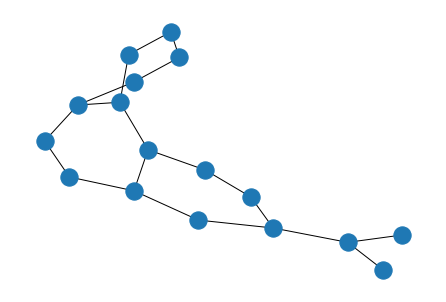

In [12]:
encoded_dataset[0].draw_graph()

We can also check the list of test graphs to make sure we have the ones we want:

In [13]:
list(map(lambda x: x.name, encoded_dataset[0].testgraphs))

['tree of size 5, number 1',
 'single_vertex',
 'c_3',
 'K_4',
 'tree of size 5, number 0',
 'tree of size 4, number 0',
 'tree of size 3, number 0',
 'c_4',
 'tree of size 4, number 1',
 'c_5',
 'tree of size 2, number 0',
 'tree of size 5, number 2']

get embedding:

In [14]:
# labels
y = np.array([data.pyg_graph().y.detach().numpy() for data in encoded_dataset]).squeeze()
# vectors
X = np.array([encoder(data, 'ghc')  for data in tqdm(encoded_dataset)])

100%|██████████| 188/188 [00:09<00:00, 20.73it/s]


Now let's evaluate the representation using a random forest classifier:

In [15]:
# evaluate
clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
scores = calculate_cv_scores(clf, X, y, 10)

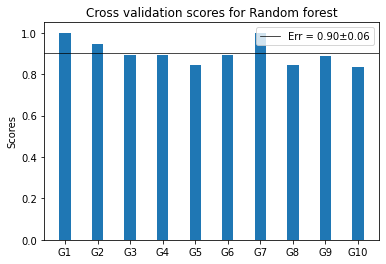

Validation error = 0.90±0.06


In [16]:
# plot scores
plot_cv_scores(scores)

### Experiment: PROTEINS

Load the data:

In [ ]:
dataset = TUDataset(root='data/TUDataset', name='PROTEINS', use_node_attr= True)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')


Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 4
Number of classes: 2

Data(edge_index=[2, 162], x=[42, 4], y=[1])


Transform:

In [ ]:
# transform PROTEINS
encoded_dataset = [encoding.grandEmbedding(data) for data in tqdm(dataset)]
__add_testgraphs = [set_testgraphs(data) for data in encoded_dataset]

100%|██████████| 1113/1113 [00:00<00:00, 3052.72it/s]


A graph from the dataset:

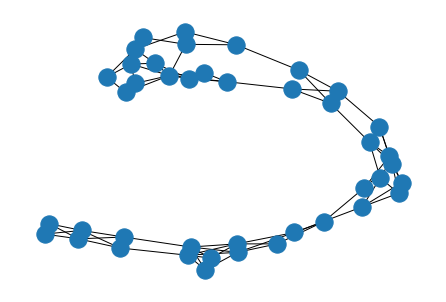

In [ ]:
encoded_dataset[0].draw_graph()

Get embedding:

In [ ]:
# labels
y = np.array([data.pyg_graph().y.detach().numpy() for data in encoded_dataset]).squeeze()

In [ ]:
# vectors
X = np.array([encoder(data, 'ghc')  for data in tqdm(encoded_dataset)])




  0%|          | 0/1113 [00:00<?, ?it/s]


  0%|          | 1/1113 [00:01<19:38,  1.06s/it]


  0%|          | 2/1113 [00:01<10:06,  1.83it/s]


  0%|          | 4/1113 [00:01<06:28,  2.85it/s]


 16%|█▌        | 177/1113 [03:07<16:33,  1.06s/it]



  1%|          | 6/1113 [00:07<36:21,  1.97s/it]


  1%|          | 7/1113 [00:09<37:19,  2.02s/it]


  1%|          | 8/1113 [00:12<39:02,  2.12s/it]


  1%|          | 9/1113 [00:12<28:01,  1.52s/it]


  1%|          | 10/1113 [00:12<20:19,  1.11s/it]


  1%|          | 11/1113 [00:12<14:58,  1.23it/s]


  1%|          | 12/1113 [00:13<18:06,  1.01it/s]


  1%|          | 13/1113 [00:14<13:43,  1.34it/s]


  1%|▏         | 14/1113 [00:15<14:39,  1.25it/s]


  1%|▏         | 15/1113 [00:15<12:34,  1.46it/s]


  1%|▏         | 16/1113 [00:15<11:20,  1.61it/s]


  2%|▏         | 17/1113 [00:16<09:48,  1.86it/s]


  2%|▏         | 18/1113 [00:19<25:00,  1.37s/it]


  2%|▏         | 19/1113 [00:20<21:31,  1.18s/it]


  2%|▏         | 20/111

Evaluation:

In [ ]:
# evaluate
clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
scores = calculate_cv_scores(clf, X, y, 10)

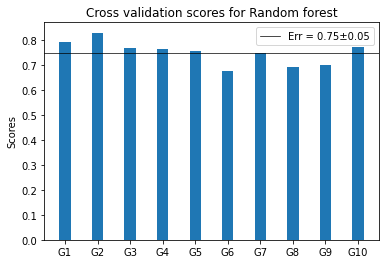

Validation error = 0.75±0.05


In [ ]:
# plot cv scores
plot_cv_scores(scores)

Now with a different encoder:

In [ ]:
# labeles:
y = np.array([data.pyg_graph().y.detach().numpy() for data in encoded_dataset]).squeeze()
# vectors
X = np.array([encoder(data, 'lagrangian_aug')  for data in tqdm(encoded_dataset)])

100%|██████████| 1113/1113 [11:46<00:00,  1.58it/s]


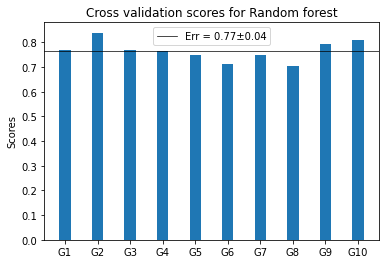

Validation error = 0.77±0.04


In [ ]:
# evaluate
clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
scores = calculate_cv_scores(clf, X, y, 10)
# plot cv scores
plot_cv_scores(scores)

### Experiment: NCI1

In [ ]:
# load the data:

dataset = TUDataset(root='data/TUDataset', name='NCI1')#, transform=transform)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

Extracting data/TUDataset/NCI1/NCI1.zip
Processing...



Dataset: NCI1(4110):
Number of graphs: 4110
Number of features: 37
Number of classes: 2

Data(edge_index=[2, 42], x=[21, 37], y=[1])


Done!


In [ ]:
# transform NCI1
encoded_dataset = [encoding.grandEmbedding(data) for data in tqdm(dataset)]
__add_testgraphs = [set_testgraphs(data) for data in encoded_dataset]


100%|██████████| 4110/4110 [00:00<00:00, 5556.06it/s]


A graph from the dataset:

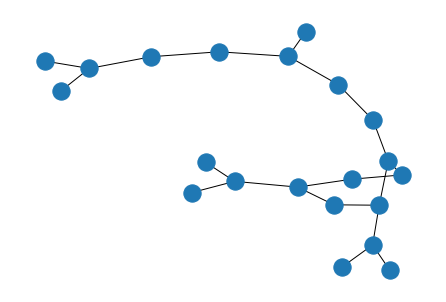

In [ ]:
encoded_dataset[0].draw_graph()

Looking at the node features, we can see that the default encoding is pretty sparse:

In [ ]:
encoded_dataset[0].pyg_graph().x

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.

So, we will probably not get something meaningful from these features with ghc aggregation. Let's try the lagrangian aggragation function (together with the usual homomorphism count)

In [ ]:
# labeles:
y = np.array([data.pyg_graph().y.detach().numpy() for data in encoded_dataset]).squeeze()
# vectors
X = np.array([encoder(data, 'lagrangian_aug')  for data in tqdm(encoded_dataset)])

Evaluate:

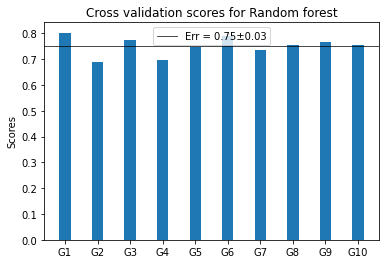

Validation error = 0.75±0.03


In [ ]:
# evaluate
clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
scores = calculate_cv_scores(clf, X, y, 10)
# plot cv scores
plot_cv_scores(scores)

### Experiment: "ogbg-molhiv" 

Loading the dataset:

In [ ]:
# setup the provided node encoder
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
emb_dim = 10
atom_encoder = AtomEncoder(emb_dim)
bond_encoder = BondEncoder(emb_dim)

class atom_transform(BaseTransform):
  def __call__(self, data):
    newdata = data.clone()
    newdata.x = atom_encoder(data.x)
    return newdata

transform = atom_transform()

In [ ]:
# load the data 
dataset = PygGraphPropPredDataset(name = "ogbg-molhiv", root = 'dataset/', transform = transform)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[7]  # Get the first graph object.

print()
print(data)
print('=============================================================')

Downloaded 0.00 GB: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 83228.82it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 35832.60it/s]


Saving...

Dataset: PygGraphPropPredDataset(41127):
Number of graphs: 41127
Number of features: 10
Number of classes: 2

Data(edge_index=[2, 38], edge_attr=[38, 3], x=[18, 10], y=[1, 1], num_nodes=18)


Done!


In [ ]:
encoded_dataset = [encoding.grandEmbedding(data) for data in tqdm(dataset)]
__add_testgraphs = [set_testgraphs(data) for data in encoded_dataset]

100%|██████████| 41127/41127 [00:23<00:00, 1726.70it/s]


Get representation (might take around 40min)

In [ ]:
# labels
y = np.array([data.pyg_graph().y[0,0].detach().numpy() for data in tqdm(encoded_dataset)])

100%|██████████| 41127/41127 [00:00<00:00, 60324.89it/s]


In [ ]:
#vectors for lagranguan_aug
X = np.array([encoder(data, 'lagrangian_aug')  for data in tqdm(encoded_dataset)])


100%|██████████| 41127/41127 [51:00<00:00, 13.44it/s]


In [ ]:
# vectors for ghc_aug
X = np.array([encoder(data, 'ghc_aug')  for data in tqdm(encoded_dataset)])


100%|██████████| 41127/41127 [54:41<00:00, 12.53it/s]


In [ ]:
X.shape, y.shape 

((41127, 132), (41127,))

#### Evaluation

We perform the evaluation according to the official procedure from Open Graph Benchmark.

In [ ]:
from ogb.graphproppred import Evaluator

evaluator = Evaluator(name = 'ogbg-molhiv')
#print(evaluator.expected_input_format) 
#print(evaluator.expected_output_format)  

get the official test-valid-train split:

In [ ]:
# Using the given train-test split

split_idx = dataset.get_idx_split()

train_idx = split_idx["train"]
valid_idx = split_idx["valid"]
test_idx  = split_idx["test"]

def molhiv_calculate_score(X, y):
  X_train , y_train = X[train_idx], y[train_idx]
  X_valid , y_valid = X[valid_idx], y[valid_idx]
  X_test , y_test = X[test_idx], y[test_idx]

  # preprocess pca
  #if i > 1:
  #  pca = PCA(n_components = 20)
  #else:
  #  pca = PCA()
  #pca.fit(X_train, y_train)

  #X_train_new = pca.transform(X_train)
  #X_valid_new = pca.transform(X_valid)
  #X_test_new = pca.transform(X_test)

  clf = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
  # fit model
  clf.fit(X_train, y_train)
  
  # calculate test auroc
  y_test_pred = clf.predict_proba(X_test)
  y_pred_test = y_test_pred[:,1].reshape(4113,1)
  y_true_test = y_test.reshape(4113,1)

  input_test_dict = {'y_true': y_true_test, 'y_pred': y_pred_test}
  test_score = evaluator.eval(input_test_dict)['rocauc']

  # calculate valid auroc
  y_valid_pred = clf.predict_proba(X_valid)
  y_pred_valid = y_valid_pred[:,1].reshape(4113,1)
  y_true_valid = y_valid.reshape(4113,1)

  input_valid_dict = {'y_true': y_true_valid, 'y_pred': y_pred_valid}
  valid_score = evaluator.eval(input_valid_dict)['rocauc']

  # calculate train auroc
  y_train_pred = clf.predict_proba(X_train)
  y_pred_train = y_train_pred[:,1].reshape(32901,1)
  y_true_train = y_train.reshape(32901,1)
  
  input_train_dict = {'y_true': y_true_train, 'y_pred': y_pred_train}
  train_score = evaluator.eval(input_train_dict)['rocauc']

  return [train_score, valid_score, test_score]

In [ ]:
# with lagrangian_aug agg
molhiv_calculate_score(X, y)
'''
<<<<< [1.0, 0.7598379629629629, 0.7170764209428534]
'''

[1.0, 0.7598379629629629, 0.7170764209428534]